In [1]:
from aeon.classification.shapelet_based import ShapeletTransformClassifier
from aeon.classification.sklearn import RotationForestClassifier
from aeon.datasets import load_unit_test
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tslearn.datasets import CachedDatasets, UCR_UEA_datasets
import matplotlib.pyplot as plt
from utils import read_UCR_UEA


/home/zwkan/miniconda3/envs/XAI2/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [2]:
task = 'GunPoint'
_, test_x, _, test_y, _ = read_UCR_UEA(task, None)
test_y = np.argmax(test_y, axis=1)
clf = ShapeletTransformClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_shapelet_samples=100,
    max_shapelet_length= test_x.shape[-1]//2,
    max_shapelets=10,
    batch_size=20,
    random_state=42,
)
clf.fit(test_x, test_y)

pred_y = clf.predict(test_x)
acc = accuracy_score(pred_y, test_y)
print(acc)

In [7]:
shapelets = clf._transformer.shapelets
ST = clf._transformer
test_x_transformed = ST.transform(test_x)
# decisionTree = clf._estimator
# pred_y = decisionTree.predict(test_x_transformed)
# acc = accuracy_score(pred_y, test_y)
# print(acc)

In [8]:
# get threshold
import numpy as np
from sklearn.metrics import mutual_info_score

def compute_best_threshold(X, y):
    num_instances, num_features = X.shape
    best_thresholds = {}

    for feature_idx in range(num_features):
        feature_values = X[:, feature_idx]
        sorted_values = np.sort(np.unique(feature_values))  # 对特征值进行排序
        best_gain = -np.inf
        best_threshold = None
        for i in range(1, len(sorted_values)):
            threshold = (sorted_values[i - 1] + sorted_values[i]) / 2


            left_mask = feature_values <= threshold
            right_mask = feature_values > threshold

            left_target = y[left_mask]
            right_target = y[right_mask]

            left_entropy = mutual_info_score(left_target, left_target)
            right_entropy = mutual_info_score(right_target, right_target)

            total_entropy = (len(left_target) * left_entropy + len(right_target) * right_entropy) / num_instances

            gain = mutual_info_score(y, y) - total_entropy

            if gain > best_gain:
                best_gain = gain
                best_threshold = threshold


        best_thresholds[feature_idx] = best_threshold

    return best_thresholds
best_thresholds = compute_best_threshold(test_x_transformed, test_y)
print(best_thresholds)

{0: 0.1131037577459118, 1: 0.003970430107326977, 2: 0.014756217302136894, 3: 0.015255035103313556, 4: 0.005835824532958207, 5: 0.006672408281727463, 6: 0.18630484615026563, 7: 0.07410040233362286, 8: 0.023002459385866154, 9: 0.005161679564114831}


In [10]:
# get existances
from collections import defaultdict

existance_index = defaultdict(list)

for i in range(len(shapelets)):
    distance_i = test_x_transformed[:,i].flatten()
    existance_index[i] = np.where(distance_i<best_thresholds[i])[0]

In [11]:
existance_index

defaultdict(list,
            {0: array([  0,   3,   4,   6,   9,  10,  11,  14,  15,  16,  20,  23,  24,
                     26,  27,  29,  30,  33,  34,  35,  37,  38,  40,  42,  43,  45,
                     48,  52,  54,  58,  60,  62,  63,  65,  66,  79,  80,  86,  88,
                     89,  90,  92,  94,  95,  98,  99, 102, 105, 106, 111, 112, 115,
                    117, 118, 120, 124, 126, 127, 132, 133, 136, 138, 139, 144, 146,
                    149]),
             1: array([  0,   3,   4,   6,   9,  11,  13,  14,  15,  16,  20,  22,  23,
                     24,  26,  27,  29,  30,  33,  34,  35,  36,  37,  38,  40,  42,
                     43,  45,  48,  51,  52,  54,  55,  58,  59,  60,  62,  63,  65,
                     66,  79,  80,  81,  88,  89,  90,  91,  94,  95,  98,  99, 100,
                    102, 105, 106, 108, 112, 114, 115, 117, 118, 120, 124, 127, 128,
                    132, 133, 134, 138, 139, 141, 142, 144, 146, 149]),
             2: array([  0,

In [13]:
# legacy observe decision tree
# tree = decisionTree.tree_

# # 4 print every best split

# shapelet_index_list = []
# shapelet_threshold_value = []
# shapelet_exist = []
# for node_id in range(tree.node_count):
#     feature_index = tree.feature[node_id]
#     threshold_value = tree.threshold[node_id]

#     if feature_index != -2:  # -2 for leaf node
#         print(f"Node {node_id}: split on feature {feature_index} (X[:, {feature_index}]) <= {threshold_value:.4f}")
#         shapelet_index_list.append(feature_index)
#         shapelet_threshold_value.append(shapelet_threshold_value)
#     else:
#         print(f"Node {node_id}: Leaf node")

The stored shapelets and relating information after a dataset has been processed. 
Each item in the list is a tuple containing the following 7 items: 

(shapelet information gain, shapelet length, start position the shapelet was extracted from, shapelet dimension, index of the instance the shapelet was extracted from in fit, class value of the shapelet, The z-normalised shapelet array)

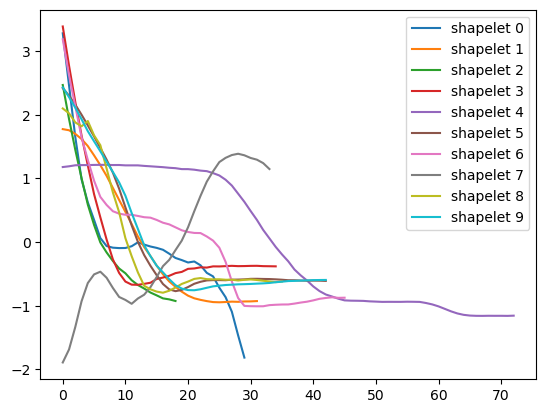

In [14]:
for i in range(len(shapelets)):
    plt.plot(shapelets[i][-1],label=f'shapelet {i}')
plt.legend()
plt.show()

In [16]:
import numpy as np

def z_normalize(ts):
    mean = np.mean(ts)
    std = np.std(ts)
    return (ts - mean) / std if std > 0 else ts - mean

# def shapelet_distance(ts, shapelet):
#     l = len(shapelet)
#     s_z = z_normalize(shapelet)
#     min_dist = float('inf')

#     for i in range(len(ts) - l + 1):
#         window = ts[i:i + l]
#         w_z = z_normalize(window)
#         dist = np.linalg.norm(w_z - s_z)
#         if dist < min_dist:
#             min_dist = dist

#     return min_dist

def match_shapelet_location(instance, shapelet):
    l = len(shapelet)
    min_dist = float('inf')
    best_loc = -1
    s_z = z_normalize(shapelet)
    min_dist = float('inf')

    for i in range(len(instance) - l + 1):
        window = instance[i:i + l]
        w_z = z_normalize(window)
        dist = np.linalg.norm(w_z - s_z)
        if dist < min_dist:
            min_dist = dist
            best_loc = i
    return best_loc, min_dist

-------Shapelet: 0---------


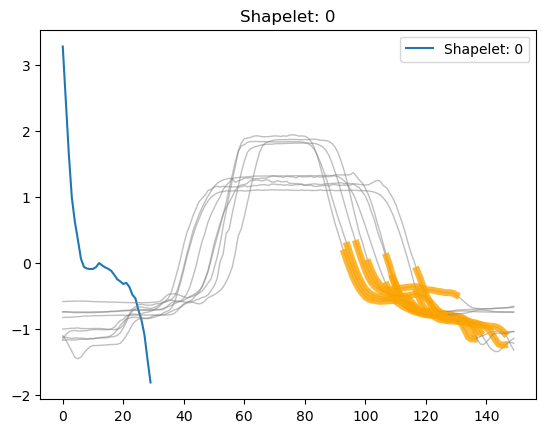

-------Shapelet: 1---------


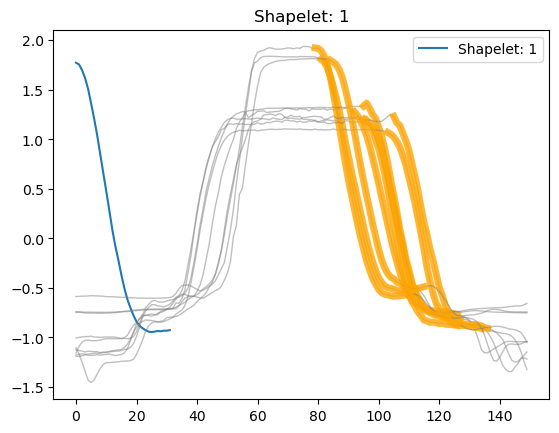

-------Shapelet: 2---------


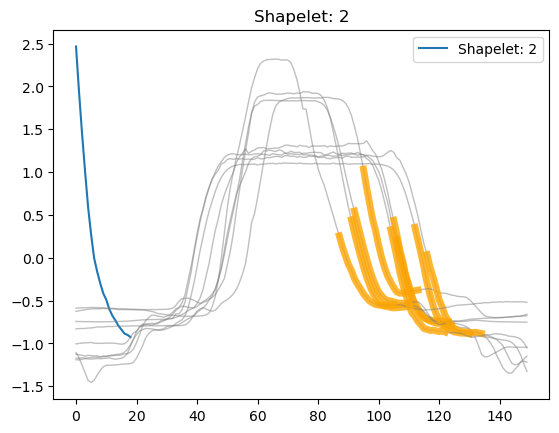

-------Shapelet: 3---------


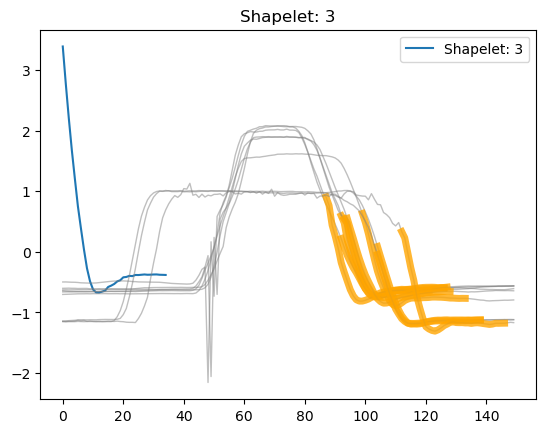

-------Shapelet: 4---------


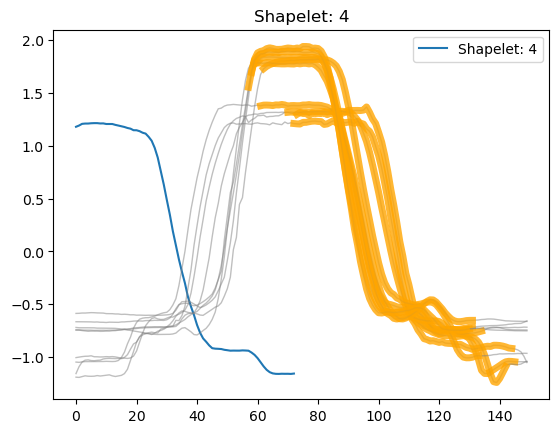

-------Shapelet: 5---------


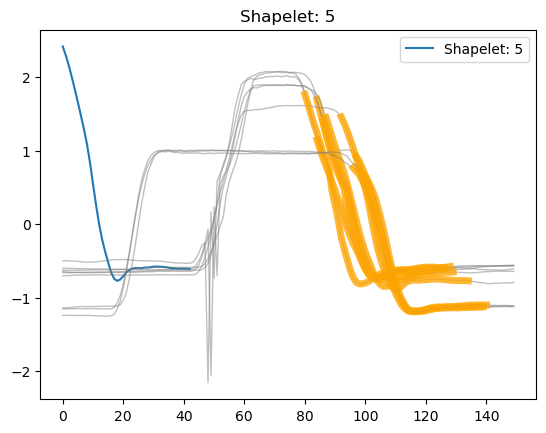

-------Shapelet: 6---------


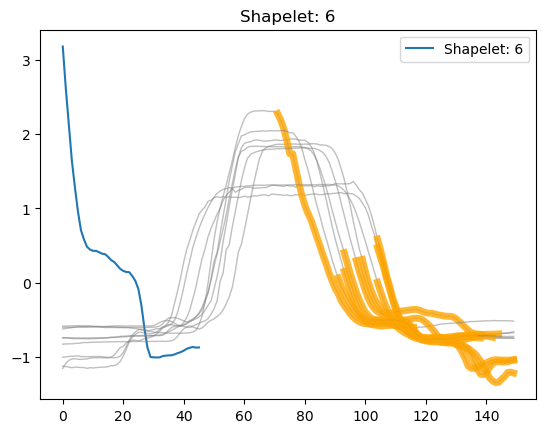

-------Shapelet: 7---------


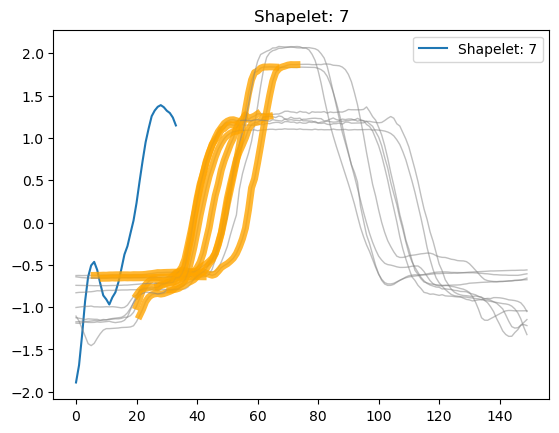

-------Shapelet: 8---------


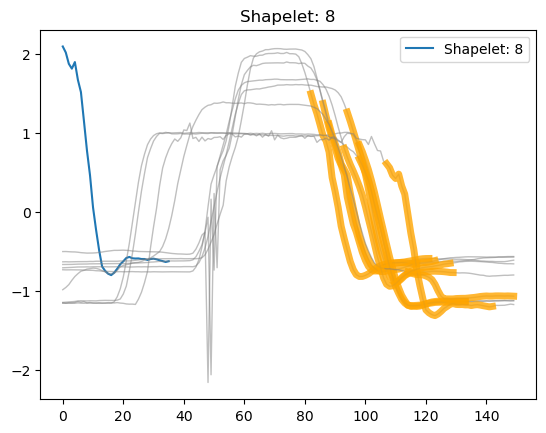

-------Shapelet: 9---------


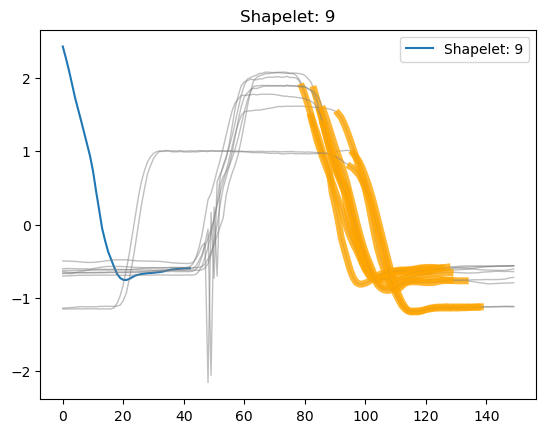

In [21]:
# find locations:
shapelet_locs = []
for index in existance_index.keys(): # 
    print(f'-------Shapelet: {index}---------')
    shapelet_info = shapelets[index]
    normalized_shapelet = shapelet_info[-1]
    # (info_gain, length,start position,dimension, index of instance,class, The z-normalised shapelet array)
    # 
    count = 0
    shapelet_length = shapelet_info[1]
    plt.plot(normalized_shapelet,label=f'Shapelet: {index}')
    for instance_index in existance_index[index]:
        best_loc, _ = match_shapelet_location(test_x[instance_index].flatten(), normalized_shapelet)
        # print(best_loc)
        shapelet_loc = [instance_index, None, None, None, best_loc, best_loc + shapelet_length]
        shapelet_locs.append(shapelet_loc)
        count += 1
        if count < 10:
            plt.plot(test_x[instance_index].flatten(),color='gray',lw=1, alpha = 0.5) #,label=instance_index
            plt.plot(np.arange(best_loc, best_loc + shapelet_length), 
                     test_x[instance_index].flatten()[best_loc: best_loc + shapelet_length],color='orange',lw=5, alpha = 0.8)
    plt.title(f'Shapelet: {index}')
    plt.legend()
    plt.show()
        # [i, inst[best_start:best_end + 1], attr[i, best_start:best_end + 1], max_score, best_start,best_end]
        # implet format [index of instance, instance subseq, attr subseq, max_score, best_start, best_end]

save_dir = f'./output/ST/{task}'

Node 0: split on feature 0 (X[:, 0]) <= 0.0357
Node 1: Leaf node
Node 2: split on feature 1 (X[:, 1]) <= 0.0017
Node 3: split on feature 8 (X[:, 8]) <= 0.0072
Node 4: Leaf node
Node 5: Leaf node
Node 6: Leaf node


## ST aeon
https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.transformations.collection.shapelet_based.RandomShapeletTransform.html#aeon.transformations.collection.shapelet_based.RandomShapeletTransform.inverse_transform

## ST classifier
https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.classification.shapelet_based.ShapeletTransformClassifier.html